In [21]:
import pandas as pd

import wordcloud
from wordcloud import WordCloud
from wordcloud import STOPWORDS

import matplotlib as plt

In [15]:
full_dataset = pd.read_csv(r'C:\Users\mupsi\Desktop\crowdsourced_curl\full_dataset_21jun.csv', dtype='string', index_col=0)

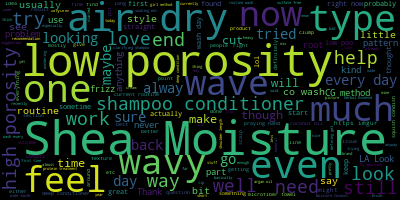

In [31]:
# generate a word cloud to identify potential topics, iterate stopwords for better insights
cloud_text = ','.join(list(full_dataset['Text'].values))

cloud_stop_words = ['curl','used', 'think', 'got','know','curls','curly','good','leave','want','thing', 'x200b','doesn','advice','head','going','hair', 'product', '2b','2c','3a','3b','3c','4a','4b','4c','lot','seem','really','aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn']+list(STOPWORDS)
wordcloud = WordCloud(background_color="black", contour_color='steelblue',stopwords = cloud_stop_words)

wordcloud.generate(cloud_text)

wordcloud.to_image()

In [32]:
# potential topics may be: porosity, dryness/frizz, moisture, co-wash

# Begin topic modeling with ScikitLearn

In [43]:
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint
import numpy as np
# following https://www.machinelearningplus.com/nlp/topic-modeling-python-sklearn-examples/ tutorial

In [34]:
# instantiate vectorizer, vectorize lemmatized text, & check percentage of no-zero datapoints in the matrix
vectorizer = CountVectorizer(analyzer='word', min_df=10, stop_words = cloud_stop_words, strip_accents = 'unicode', ngram_range=(1,3), max_features=2500)
vectorized_txt = vectorizer.fit_transform(full_dataset['lemmatized_txt'])
data_dense = vectorized_txt.todense()
print("Sparsicity: ", ((data_dense > 0).sum()/data_dense.size)*100, "%")

In [39]:
# try LDA on 5 topics (components)
lda_model = LatentDirichletAllocation(n_components=5, random_state=100)
lda_output = lda_model.fit_transform(vectorized_txt)
print(lda_model)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=5, n_jobs=None,
                          perp_tol=0.1, random_state=100, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)


In [40]:
# looking for high LL & low perplexity
print("Log Likelihood: ", lda_model.score(vectorized_txt))
print("Perplexity: ", lda_model.perplexity(vectorized_txt))

Log Likelihood:  -11523476.135550253
Perplexity:  960.7112935005607


In [44]:
# Show top n keywords for each topic
def show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=20)        

# Topic-Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15,Word 16,Word 17,Word 18,Word 19
Topic 0,look,straight,wavy,time,wave,day,year,long,pattern,people,started,length,month,way,say,feel,right,method,layer,different
Topic 1,dry,day,wash,use,wet,shower,conditioner,brush,water,air,time,comb,scrunch,root,frizz,end,gel,air dry,look,finger
Topic 2,shea,moisture,shea moisture,conditioner,coconut,shampoo,oil,hibiscus,wash,use,smoothie,coconut hibiscus,day,moisture coconut,dry,shea moisture coconut,cantu,castor,moisture coconut hibiscus,shine
Topic 3,gel,conditioner,dry,scrunch,look,devacurl,use,day,mousse,wash,plop,hold,la,cream,porosity,air,shampoo,condition,squish,la look
Topic 4,conditioner,shampoo,use,oil,porosity,protein,moisture,wash,deep,fine,free,cream,shampoo conditioner,gel,dry,high,sulfate,scalp,coconut,silicone


In [45]:
# could be some coherent topics here but better to see if there are better models

In [ ]:
# Gridsearch for the best model - this takes a bit of time

search_params = {'n_components': [5,8,10,11], 'learning_decay':[.5, .7, .9],  'random_state':[100]}
lda = LatentDirichletAllocation()
model = GridSearchCV(lda, param_grid = search_params)
model.fit(vectorized_txt)

In [ ]:
# best model?
model.best_estimator_
model.best_params_

In [ ]:
# coherent topics for that model?
show_topics(vectorizer, best_lda_model, n_words = 20)

In [ ]:
# T0: Morning/nighttime routines
# T1: Devacurl, curl definition
# T2: Drying methods (air, plopping, diffuser)
# T3: Porosity/density
# T4: Frizz/curl definition for wavy hair
# T5: Moisture/Mask treatments
# T6: Detangling
# T7: Heat Damage/Growing advice

In [ ]:
# Assign top topic to each document - each topic gets a 
topic_values = best_lda_model.transform(vectorized_txt)
topic_values.shape


def topic_values_to_df(model = best_lda_model, df = df1):
    topic_values_fn = model.transform(vectorized_txt)
    top_df_fn = pd.DataFrame((np.argpartition(-topic_values, 4, axis=1)[:, :4]), columns = ['First_Topic','Second_Topic','Third_Topic','Fourth_Topic'])
    df_top_topics = pd.concat([df, top_df_fn], axis=1)
    return df_top_topics
full_datset_topics = topic_values_to_df()